https://sentimentbau.streamlit.app/

In [1]:
pip install mysql-connector

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


# Import Libraries

In [3]:
import mysql.connector as sql
import numpy as np
import pandas as pd
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from lazypredict.Supervised import LazyRegressor
from tqdm.notebook import tqdm
from nltk.stem import PorterStemmer
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report,r2_score

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\W10\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Read Data

In [4]:
mydb=sql.connect(host="localhost",user="root",password="7moood58",database="sales",auth_plugin="mysql_native_password")
cur=mydb.cursor(buffered=True)

In [5]:
query1="show tables"
cur.execute(query1)
data_bases=cur.fetchall()
for table in data_bases:
    print(table)

('dim_customer',)
('dim_location',)
('dim_order',)
('dim_product',)
('dim_ship',)
('fact_sales',)
('review',)


In [6]:
query="select * from review"
cur.execute(query)

In [7]:
data=pd.read_sql(query,mydb)
data

,review_key,review,Rating,customer_id
0,294919,Five Stars,5,TB-21400
1,294920,Not Keto Not for Diabetics,1,JG-15805
2,294921,used it for my toilet bowl container. does sam...,5,GZ-14470
3,294922,Perfect drop in upgrade straight out of the pa...,5,EB-14110
4,294923,Solid Office Chair! I love It!,4,BT-11440
...,...,...,...,...
8228,303147,Strong and long lasting,5,JC-15775
8229,303148,Five Stars,5,EN-13780
8230,303149,Five Stars,5,TP-21415
8231,303150,Useful for cleaning the litter box,5,CV-12805


# Information 

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8233 entries, 0 to 8232
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_key   8233 non-null   int64 
 1   review       8233 non-null   object
 2   Rating       8233 non-null   int64 
 3   customer_id  8233 non-null   object
dtypes: int64(2), object(2)
memory usage: 257.4+ KB


5    5192
4    1295
3     710
1     598
2     438
Name: Rating, dtype: int64

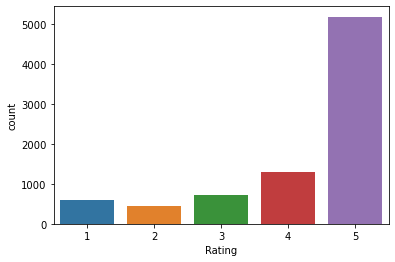

In [9]:
sns.countplot(data['Rating'])
data['Rating'].value_counts()

# Pre-processing Data

In [10]:
a=data['review'][22]
b=data['Rating'][22]
print(a)
print(b)

Good product for the price & for just keeping pets seated
5


In [11]:
a=re.sub('[^a-zA-Z,]',' ',a)
a

'Good product for the price   for just keeping pets seated'

In [12]:
a=a.lower()
a

'good product for the price   for just keeping pets seated'

In [13]:
a=a.split()
a

['good',
 'product',
 'for',
 'the',
 'price',
 'for',
 'just',
 'keeping',
 'pets',
 'seated']

In [14]:
a1=[]
for word in a:
    if word not in stopwords.words('english'):
        a1.append(word)
    if word in (['not','very','more']):
        a1.append(word)
a1

['good', 'product', 'price', 'keeping', 'pets', 'seated']

In [15]:
s=PorterStemmer()
a2=[]
for i in a1:
    b=s.stem(i)
    a2.append(b)
a2

['good', 'product', 'price', 'keep', 'pet', 'seat']

In [16]:
a=' '.join(a2)
a

'good product price keep pet seat'

In [17]:
cv=TfidfVectorizer()
cv.fit_transform(a.split()).toarray()

array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.]])

In [18]:
rev=[]

for i in range(len(data)):
    data1=re.sub('[^a-zA-Z]',' ',data['review'][i])
    data1=data1.lower()
    data1=data1.split()
    data1=[w for w in data1 if w not in stopwords.words('english') or w in ['not','very','more',]]
    data1=[s.stem(i) for i in data1]
    data1=' '.join(data1)
    rev.append(data1)
rev

['five star',
 'not keto not diabet',
 'use toilet bowl contain',
 'perfect drop upgrad straight packag',
 'solid offic chair love',
 'wire sorter work great art work',
 'suppos non chines salt not sure',
 'pot great would recommend anyon use',
 'good qualiti look',
 'excel cat litter box scooper',
 'boy love flavor tummi issu',
 'good deal',
 'keto approv dessert',
 'love case',
 'favorit cracker moment',
 'favorit',
 'five star',
 'turn perfect',
 'cheap flimsi',
 'great size',
 'five star',
 '',
 'good product price keep pet seat',
 'five star',
 'five star',
 'fri food',
 'light weight compact easi storag easi use complic sandwich combo learn',
 'larg size cozi',
 'wast money',
 'read',
 'lot use great product',
 'cat super thrill',
 'game changer',
 'love love love',
 'cap doesnt fit',
 'good may crack',
 'good ruler print wear',
 'two star',
 'four star',
 'cute clever good qualiti card',
 'great chair',
 'ingredi chang worst',
 'work pug',
 'four star',
 'last long great go bake

In [19]:
x=cv.fit_transform(rev).toarray()
x.shape

(8233, 3498)

In [20]:
y=data['Rating']

In [21]:
strategy = {1:5339, 2:5339, 3:5339, 4:5339, 5:5339}
oversample = SMOTE(sampling_strategy=strategy)
x, y = oversample.fit_resample(x, y)

<AxesSubplot:xlabel='Rating', ylabel='count'>

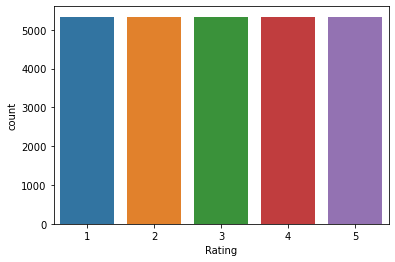

In [22]:
sns.countplot(y)

# Model

In [23]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=40)

In [24]:
x_train.shape

(21356, 3498)

In [25]:
y_train.shape

(21356,)

In [26]:
x.reshape(1,-1)

array([[0., 0., 0., ..., 0., 0., 0.]])

In [27]:
nv=MultinomialNB()

In [28]:
nv.fit(x_train,y_train)

MultinomialNB()

In [29]:
y_pred=nv.predict(x_test)

In [30]:
x_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Evaluation

In [31]:
print(confusion_matrix(y_test,y_pred))

[[906  92  36  13  12]
 [ 55 922  59  16   8]
 [ 71  69 808  38  56]
 [ 49  74  81 743 186]
 [ 46  49  67 145 738]]


In [32]:
print(accuracy_score(y_test,y_pred))

0.7711181869263907


In [33]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.80      0.86      0.83      1059
           2       0.76      0.87      0.81      1060
           3       0.77      0.78      0.77      1042
           4       0.78      0.66      0.71      1133
           5       0.74      0.71      0.72      1045

    accuracy                           0.77      5339
   macro avg       0.77      0.77      0.77      5339
weighted avg       0.77      0.77      0.77      5339



In [34]:
x.shape

(26695, 3498)

In [1]:
z=input()
z=re.sub('[^a-zA-Z]',' ',z)
z=z.lower()
z=z.split()
z1=[]
for word in z:
    if word not in stopwords.words('english'):
        z1.append(word)
    if word in (['not','very','more','wasnt']):
        a1.append(word)
s=PorterStemmer()
z2=[]
for i in z1:
    v=s.stem(i)
    z2.append(v)
z2
z=' '.join(z2)
z=np.array([z])
z1=cv.transform(z)
print(z1)
nv.predict(z1)

bad product


NameError: name 're' is not defined

In [36]:
x_test.shape

(5339, 3498)

In [37]:
import pickle 
with open('finalized_model.pkl','wb') as fout:
    pickle.dump((cv,nv),fout)

# Example

In [38]:
import pandas as pd

In [39]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\W10\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
from nltk.sentiment import SentimentIntensityAnalyzer

In [3]:
sia=SentimentIntensityAnalyzer()

In [42]:
dicc={}
for i , row in tqdm(data.iterrows(),total=len(data)):
    text=row['Review']
    myid=row['customer_id']
    dicc[myid]=sia.polarity_scores(text)
dicc

  0%|          | 0/8233 [00:00<?, ?it/s]

KeyError: 'Review'

In [ ]:
data1=pd.DataFrame(dicc).T
data1

In [ ]:
data.set_index('customer_id',inplace=True)

In [ ]:
data

In [ ]:
data1=data1.join(data)

In [ ]:
data1.info()

In [ ]:
data1

In [ ]:
X=np.array(data1[['neg','neu','pos','compound']])
Y=data1[['Rating']]
X

In [ ]:
strategy = {1:4000, 2:4000, 3:4000, 4:5000, 5:5339}
oversample = SMOTE(sampling_strategy=strategy)
x, y = oversample.fit_resample(X, Y)

In [ ]:
X_train,X_test,Y_train,Y_test=train_test_split(x,y,test_size=0.2,random_state=45)

In [ ]:
nv=MultinomialNB()

In [ ]:
nv.fit(X_train,Y_train)

In [ ]:
y_pred=nv.predict(X_test)

In [ ]:
print(confusion_matrix(Y_test,y_pred))

In [ ]:
print(accuracy_score(Y_test,y_pred))

In [ ]:
dc=KNeighborsClassifier(100)

In [ ]:
dc.fit(X_train,Y_train)

In [ ]:
Y_pred1=dc.predict(X_test)

In [ ]:
print(confusion_matrix(Y_test,Y_pred1))

In [ ]:
print(accuracy_score(Y_test,Y_pred1))

In [ ]:
lr=LogisticRegression()

In [ ]:
lr.fit(X_train,Y_train)

In [ ]:
Y_pred=lr.predict(X_test)

In [ ]:
print(accuracy_score(Y_test,Y_pred))

In [ ]:
z=sia.polarity_scores('one star')
a=np.array(list(z.values())).reshape(1,-1)
print(a)
lr.predict(a)

In [ ]:
r=RandomForestClassifier()

In [ ]:
r.fit(X_train,Y_train)

In [ ]:
Y_pred2=r.predict(X_test)

In [ ]:
print(confusion_matrix(Y_test,Y_pred2))

In [ ]:
print(accuracy_score(Y_test,Y_pred2))

In [ ]:
x=sia.polarity_scores('fucking amazing')
x

In [ ]:
data=pd.DataFrame.from_dict(x).reset_index()
data

In [4]:
sia.polarity_scores('I enjoy reading this to my grandsons.  Its not as funny as the wordless Frog books, but its fun to read')

{'neg': 0.067, 'neu': 0.673, 'pos': 0.259, 'compound': 0.7047}

In [9]:
sia.polarity_scores('you are stupid')

{'neg': 0.63, 'neu': 0.37, 'pos': 0.0, 'compound': -0.5267}